# [MLP_enhance] BatchNorm & Dropout을 통한 개선
- **Previous (MLP_base)**: 성능은 좋은데, 재수 없으면 학습이 망할 것 같이 위태로웠다.
- **Analysis**: 층을 지날 때마다 데이터 분포가 쏠리는 현상(Internal Covariate Shift) 때문일 것이다. 그리고 특정 특징에만 너무 의존하는(Overfitting) 경향도 보인다.
- **Solution**: 현업에서 쓰는 '치트키' 2개를 도입한다.
    1. **Batch Norm**: 데이터의 중심을 강제로 맞춰준다.
    2. **Dropout**: 일부 뉴런을 강제로 끄고 공부시켜 응용력을 키운다.


# 1. 라이브러리 임포트 (Libraries)

In [46]:
# 1. 파이썬 기본 도구 (시스템 관련)
import sys # 파이썬 시스템(System)을 건드리는 도구
import os  # 컴퓨터 운영체제(OS, 폴더 경로 등)를 다루는 도구

# 2. 데이터 다루는 도구 (엑셀, 계산기)
import pandas as pd  # '표(Table)'를 다루는 엑셀 같은 도구
import numpy as np   # '숫자(Number)' 계산을 엄청 빠르게 하는 도구

# 3. 딥러닝 도구 (PyTorch)
import torch
import torch.nn as nn        # 딥러닝 모델의 '층(Layer)'을 만드는 도구
import torch.optim as optim  # 모델을 '학습(Train)'시키는 최적화 도구
from torch.utils.data import DataLoader, TensorDataset  # 데이터를 '배치(Batch)' 단위로 묶는 도구

# 4. 머신러닝 도구 (Scikit-learn)
from sklearn.model_selection import train_test_split  # 데이터를 학습용/시험용으로 나누는 도구
from sklearn.preprocessing import StandardScaler  # 데이터 범위를 일정하게 맞추는 도구 (스케일링)
from imblearn.over_sampling import SMOTE  # 불균형한 데이터 비율을 맞춰주는 도구 (오버샘플링)

# 5. 하이퍼파라미터 튜닝 (Optuna)
import optuna

# 5. 프로젝트 경로 설정
# 현재 위치(notebooks/dl)에서 두 단계 상위('../../')를 프로젝트 루트로 인식시킴
sys.path.append(os.path.abspath('../../'))

# 6. 사용자 정의 모듈 (우리가 만든 코드)
from models.model_definitions import MLP_enhance  # 모델 설계도 가져오기
from app.utils.metrics import evaluate_churn_metrics  # 평가 지표 계산기 가져오기


### 데이터 파이프라인 유지
- **원칙**: DL1과 데이터는 **100% 동일**해야 한다.
- **이유**: 그래야 "모델을 바꿔서 성능이 좋아진 건지", "데이터가 바뀐 건지" 헷갈리지 않는다. 과학적 실험의 기본(Control Variable)이다.

# 2. 데이터 로드 및 전처리 (Data Load & Transformation)

In [47]:
# 1. 로딩 시작 메시지
print('로딩중~')

# 2. 데이터 파일 경로 설정
# 전처리된 데이터가 저장된 폴더 위치
base_path = "/Users/gimdabin/SKN23-2nd-3Team/data/processed/"

# 3. Parquet 파일 읽기 (CSV보다 빠르고 가벼움)
anchors = pd.read_parquet(base_path + "anchors.parquet")            # 기준점 (누가, 언제)
features = pd.read_parquet(base_path + "features_ml_clean.parquet") # 특징 (무엇을 했나)
labels = pd.read_parquet(base_path + "labels.parquet")              # 정답 (이탈했나?)

# 4. ID 컬럼 형식 통일
# 숫자와 문자가 섞이지 않도록 모두 문자열(string)로 변환
anchors['user_id'] = anchors['user_id'].astype(str)
features['user_id'] = features['user_id'].astype(str)
labels['user_id'] = labels['user_id'].astype(str)

# 5. 데이터 병합 (Merge)
# 세 개의 테이블을 'user_id'와 'anchor_time' 기준으로 하나로 합침
data = anchors.merge(features, on=['user_id', 'anchor_time'], how='inner')
data = data.merge(labels, on=['user_id', 'anchor_time'], how='inner')

# 6. 타겟 변수 생성 (Target)
# label이 'm2'(이탈)면 1, 아니면 0으로 변환하여 컴퓨터가 이해하도록 함
data['target'] = (data['label'] == 'm2').astype(int)

# 7. 특징(Feature)과 정답(Label) 분리
# 학습에 방해되는 식별자(ID, 시간)는 제거 -> 과적합 방지
# 누구냐는 중요하지않고 공부를 얼마나 했냐를 보고 판단하도록, 날짜에 따라서 이상한 규칙을 만들지 않도록
feature_cols = [c for c in features.columns if c not in ['user_id', 'anchor_time']]
X = data[feature_cols].copy().fillna(0)  # 빈 값(NaN)은 0으로 채움
y = data['target'].values                # 정답 값만 추출

# 8. 데이터 나누기 (Train/Val/Test Split)
# 전체 데이터를 6:2:2 비율로 나눔 (stratify=y: 정답 비율 유지)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.4,   # 테스트 데이터 40%
    random_state=42, # 랜덤 시드 설정 (재현 가능)
    stratify=y       # 정답 비율 유지
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,   # 검증 데이터 50%
    random_state=42, # 랜덤 시드 설정 (재현 가능)
    stratify=y_temp   # 정답 비율 유지
)

# 9. 데이터 불균형 해소 (SMOTE)
# 이탈 데이터(소수)를 복제하여 1:1 비율로 맞춤 (학습 데이터에만 적용)
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# 10. 스케일링 (Scaling)
# 값의 범위를 비슷하게 맞춤 (예: 0~1 사이, 또는 평균 0)
scaler = StandardScaler() 
X_train_scaled = scaler.fit_transform(X_train_res) # 기준점을 학습데이터로 설정 후 Numpy배열로 변환
X_val_scaled = scaler.transform(X_val)             # 검증 데이터 Numpy배열로 변환
X_test_scaled = scaler.transform(X_test)           # 테스트 데이터 Numpy배열로 변환

# 11. 데이터로더 생성 (DataLoader)
# 딥러닝 모델에 데이터를 조금씩(Batch) 먹여주기 위한 포장 작업
train_loader = DataLoader(
    TensorDataset(
        torch.FloatTensor(X_train_scaled), # Numpy배열을 PyTorch 텐서로 변환
        torch.FloatTensor(y_train_res)     # Numpy배열을 PyTorch 텐서로 변환
        ), batch_size=256, shuffle=True)   # batch_size: 한 번에 처리할 데이터의 크기, shuffle: 데이터를 무작위로 섞음
val_loader = DataLoader(
    TensorDataset(
        torch.FloatTensor(X_val_scaled),   # Numpy배열을 PyTorch 텐서로 변환
        torch.FloatTensor(y_val)           # Numpy배열을 PyTorch 텐서로 변환
        ), batch_size=256)
test_loader = DataLoader(
    TensorDataset(
        torch.FloatTensor(X_test_scaled),  # Numpy배열을 PyTorch 텐서로 변환
        torch.FloatTensor(y_test)          # Numpy배열을 PyTorch 텐서로 변환
        ), batch_size=256)

로딩중~


- Train, Val, Test로 나눈 이유 -> 과적합방지
    - Train (학습 데이터): 교과서. 열심히 공부해서 지식을 쌓는 용도.
    - Val (검증 데이터): 모의고사. 공부하는 도중에 "내가 잘하고 있나?" 수시로 체크하고, 공부 방향(하이퍼파라미터)을 고치는 용도.
    - Test (테스트 데이터): 수능(최종 시험). 학습이 다 끝나고 나서 딱 한 번만 실력을 검증하는 용도.
        - train -> val -> test 순으로 test를 끝까지 숨겨서 과적합을 방지

- train 60%, val 20%, test 20%로 분리

- FloatTensor 의 이유
    - scaler.fit_transform( )을 실행하면, 사이킷런(Scikit-learn)이 데이터를 변환한 뒤 자동으로 넘파이 배열(Numpy Array) 형태로 뱉어냄
    - 이 numpy배열을 pytorch는 이해할 수 없으니 FloatTensor형태로 변환하는것

### 👨‍💻 Developer's Log: 구조 개선 (Stabilization)
- **변경점**: `Linear` 다음에 바로 `ReLU`를 쓰던 DL1과 달리, `Linear -> BN -> ReLU -> Dropout` 순서로 블록을 짰다.
- **기대효과**:
    1. **BN**: 학습이 빨라지고, Loss 곡선이 예쁘게 떨어질 것이다.
    2. **Dropout**: Training 점수와 Test 점수 차이(Gap)가 줄어들 것이다. (Overfitting 방지)

# 3. Optuna를 활용한 하이퍼파라미터 튜닝 (Hyperparameter Tuning)
- 모델의 성능을 극대화하기 위해 최적의 하이퍼파라미터(LR, Hidden Dim, Dropout 등)를 찾습니다.

### 👨‍💻 Developer's Log: 스마트한 튜닝 전략 (Efficiency & Accuracy)
- **고민**: 모든 파라미터를 다 튜닝하고 싶지만, 무작정 돌리면 시간이 너무 오래 걸린다.
- **해결책**: **'TPE Sampler'**와 **'Hyperband Pruner'**의 조합.
    1. **TPE (Tree-structured Parzen Estimator)**: 멍청하게 랜덤으로 찾는 게 아니라, '이전에 잘 나왔던 설정'을 참고해서 더 똑똑하게 찍는다.
    2. **Hyperband Pruner (가지치기)**: 가망 없는 시도는 초반에 과감하게 잘라낸다(Early Stopping). 자원 낭비를 최소화한다.
- **목표**: 최소한의 시간으로 최대한 꼼꼼하게(Thorough) 최적의 조합을 찾아낸다.

In [48]:
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import HyperbandPruner

def objective(trial):
    # 1. Hyperparameter Suggestion
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-3, log=True)
    hidden_dim = trial.suggest_categorical('hidden_dim', [64, 128, 256, 512])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    epochs = trial.suggest_int('epochs', 5, 20)
    activation = trial.suggest_categorical('activation', ['relu', 'leaky_relu', 'tanh', 'elu'])
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'AdamW', 'SGD', 'RMSprop'])

    # 2. Model Initialization (Dynamic)
    try:
        model = MLP_enhance(X.shape[1], hidden_dim=hidden_dim, dropout_rate=dropout_rate, activation=activation)
    except TypeError:
        model = MLP_enhance(X.shape[1], hidden_dim=hidden_dim)

    # 3. Loss & Optimizer
    criterion = nn.BCEWithLogitsLoss()

    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name == 'AdamW':
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
    elif optimizer_name == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)

    # 4. Training Loop (with Pruning)
    for epoch in range(epochs):
        model.train()
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

        # Validation for Pruning
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, targets)
                val_loss += loss.item()
        avg_val_loss = val_loss / len(val_loader)

        # Pruning Check
        trial.report(avg_val_loss, epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()

    return avg_val_loss

# [Smart Tuning Execution]
print("🚀 [Smart Tuning] 초고속/초정밀 하이퍼파라미터 튜닝 시작... (TPE + Hyperband)")
sampler = TPESampler(seed=42)
pruner = HyperbandPruner(min_resource=1, max_resource=20, reduction_factor=3)

study = optuna.create_study(direction='minimize', sampler=sampler, pruner=pruner)
study.optimize(objective, n_trials=20)

print(f"✅ 튜닝 완료! Best Params: {study.best_params}")

# [Global Variable Export] 중요: 최적 파라미터를 전역 변수로 확정
best_params = study.best_params
lr = best_params['lr']
weight_decay = best_params['weight_decay']
hidden_dim = best_params['hidden_dim']
dropout_rate = best_params['dropout_rate']
epochs = best_params['epochs']
activation = best_params['activation']
optimizer_name = best_params['optimizer']


[I 2026-01-12 16:10:44,824] A new study created in memory with name: no-name-36ba1344-1b60-48e5-ba84-e9e8d317b567


🚀 [Smart Tuning] 초고속/초정밀 하이퍼파라미터 튜닝 시작... (TPE + Hyperband)


[I 2026-01-12 16:12:56,904] Trial 0 finished with value: 0.6322586934708949 and parameters: {'lr': 0.0005611516415334506, 'weight_decay': 0.0007969454818643932, 'hidden_dim': 64, 'dropout_rate': 0.12323344486727979, 'epochs': 18, 'activation': 'elu', 'optimizer': 'Adam'}. Best is trial 0 with value: 0.6322586934708949.
[I 2026-01-12 16:14:29,368] Trial 1 finished with value: 0.625309261229803 and parameters: {'lr': 0.0004059611610484307, 'weight_decay': 0.00011207606211860574, 'hidden_dim': 256, 'dropout_rate': 0.21685785941408728, 'epochs': 10, 'activation': 'leaky_relu', 'optimizer': 'SGD'}. Best is trial 1 with value: 0.625309261229803.
[I 2026-01-12 16:14:46,606] Trial 2 pruned. 
[I 2026-01-12 16:15:02,642] Trial 3 pruned. 
[I 2026-01-12 16:17:30,691] Trial 4 finished with value: 0.6006313737645839 and parameters: {'lr': 0.0003646439558980723, 'weight_decay': 0.00012172847081122418, 'hidden_dim': 512, 'dropout_rate': 0.40889790771866297, 'epochs': 8, 'activation': 'leaky_relu', 'op

KeyboardInterrupt: 

In [ ]:
# 1. 최적 하이퍼파라미터 적용 및 학습 준비
# (Optuna 튜닝 셀에서 전역 변수로 설정된 값들을 그대로 사용합니다)
print(f"\n>>> [Final Training] Best Params Applied:")
print(f"    - Model: MLP_enhance")
print(f"    - Optimizer: {optimizer_name} (lr={lr:.5f}, weight_decay={weight_decay:.5f})")
print(f"    - Activation: {activation}")
print(f"    - Hidden Dim: {hidden_dim}")
print(f"    - Dropout: {dropout_rate:.4f}")
print(f"    - Epochs: {epochs}")

# [Model] 모델 재생성 (Clean Instantiation)
model = MLP_enhance(X.shape[1], hidden_dim=hidden_dim, dropout_rate=dropout_rate, activation=activation)

# [Loss Function] 손실 함수 정의
criterion = nn.BCEWithLogitsLoss()

# [Optimizer] 옵티마이저 설정
if optimizer_name == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
elif optimizer_name == 'AdamW':
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
elif optimizer_name == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
elif optimizer_name == 'RMSprop':
    optimizer = optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)

# [Training Loop] 최종 학습 진행
print("\n>>> Starting Training Loop...")
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    print(f'Epoch {epoch+1:02d}/{epochs}: Loss {epoch_loss/len(train_loader):.4f}')



>>> [Final Training] Best Params Applied:
    - Model: MLP_enhance
    - Optimizer: AdamW (lr=0.00555, weight_decay=0.00017)
    - Activation: relu
    - Hidden Dim: 256
    - Dropout: 0.2511
    - Epochs: 12

>>> Starting Training Loop...
Epoch 01/12: Loss 0.6265
Epoch 02/12: Loss 0.6199
Epoch 03/12: Loss 0.6164
Epoch 04/12: Loss 0.6143
Epoch 05/12: Loss 0.6129
Epoch 06/12: Loss 0.6121
Epoch 07/12: Loss 0.6111
Epoch 08/12: Loss 0.6107
Epoch 09/12: Loss 0.6101
Epoch 10/12: Loss 0.6094
Epoch 11/12: Loss 0.6092
Epoch 12/12: Loss 0.6090


# 4. 최종 모델 학습 (Final Training with Best Params)

In [ ]:
# 1. 최적 하이퍼파라미터 적용 및 학습 준비
# (Optuna 튜닝 셀에서 전역 변수로 설정된 값들을 그대로 사용합니다)
print(f"\n>>> [Final Training] Best Params Applied:")
print(f"    - Model: MLP_enhance")
print(f"    - Optimizer: {optimizer_name} (lr={lr:.5f}, weight_decay={weight_decay:.5f})")
print(f"    - Activation: {activation}")
print(f"    - Hidden Dim: {hidden_dim}")
print(f"    - Dropout: {dropout_rate:.4f}")
print(f"    - Epochs: {epochs}")

# [Model] 모델 재생성 (Clean Instantiation)
model = MLP_enhance(X.shape[1], hidden_dim=hidden_dim, dropout_rate=dropout_rate, activation=activation)

# [Loss Function] 손실 함수 정의
criterion = nn.BCEWithLogitsLoss()

# [Optimizer] 옵티마이저 설정
if optimizer_name == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
elif optimizer_name == 'AdamW':
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
elif optimizer_name == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
elif optimizer_name == 'RMSprop':
    optimizer = optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)

# [Training Loop] 최종 학습 진행
print("\n>>> Starting Training Loop...")
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    print(f'Epoch {epoch+1:02d}/{epochs}: Loss {epoch_loss/len(train_loader):.4f}')



>>> [Final Training] Best Params Applied:
    - Model: MLP_enhance
    - Optimizer: AdamW (lr=0.00555, weight_decay=0.00017)
    - Activation: relu
    - Hidden Dim: 256
    - Dropout: 0.2511
    - Epochs: 12

>>> Starting Training Loop...
Epoch 01/12: Loss 0.6266
Epoch 02/12: Loss 0.6202
Epoch 03/12: Loss 0.6165
Epoch 04/12: Loss 0.6143
Epoch 05/12: Loss 0.6130
Epoch 06/12: Loss 0.6118
Epoch 07/12: Loss 0.6111
Epoch 08/12: Loss 0.6106
Epoch 09/12: Loss 0.6101
Epoch 10/12: Loss 0.6095
Epoch 11/12: Loss 0.6094
Epoch 12/12: Loss 0.6090


### 👨‍💻 Developer's Log: 만족, 그리고 욕심
- **성과**: 역시 BN과 Dropout은 배신하지 않는다. 모델이 훨씬 안정적이다. 현업에서 DL2 정도면 "배포 가능한 수준"이다.
- **욕심**: 하지만 엔지니어로서 궁금하다. 이미지 처리 분야에서 쓴다는 **SOTA(State-of-the-Art) 기술**들을 쓰면 얼마나 더 좋아질까?
- **Next Step**: "끝을 보자." ResNet의 Residual Connection, 그리고 어려운 문제에 집중하는 Focal Loss까지 다 넣어보자.

👉 **[Next: DL3.ipynb - The Over-Engineering]**

# 5. 모델 평가 및 결과 저장 (Evaluation & Artifacts)

>>> Generating Verification Dashboard (Korean)...



### 📊 주요 성능 지표

,KPI,Value
0,PR-AUC (Average Precision),0.898414
1,상위 5% 정밀도 (Precision),0.941610
2,상위 5% 재현율 (Recall),0.057528
3,상위 5% 리프트 (Lift),1.150613


### 📈 상세 랭킹 지표 (Top K%)

,Top_K,Precision,Recall,Lift
0,5%,0.941610,0.057528,1.150613
1,10%,0.934050,0.114132,1.141375
2,15%,0.929648,0.170398,1.135996
3,20%,0.925233,0.226116,1.130600
4,25%,0.920643,0.281248,1.124992
5,30%,0.915574,0.335636,1.118797


/var/folders/51/k_yn4qxs0_nfrm1hk39_0m2r0000gn/T/ipykernel_72272/2520853021.py:59: UserWarning: Glyph 51116 (\N{HANGUL SYLLABLE JAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/51/k_yn4qxs0_nfrm1hk39_0m2r0000gn/T/ipykernel_72272/2520853021.py:59: UserWarning: Glyph 54788 (\N{HANGUL SYLLABLE HYEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/51/k_yn4qxs0_nfrm1hk39_0m2r0000gn/T/ipykernel_72272/2520853021.py:59: UserWarning: Glyph 50984 (\N{HANGUL SYLLABLE YUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/51/k_yn4qxs0_nfrm1hk39_0m2r0000gn/T/ipykernel_72272/2520853021.py:59: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/51/k_yn4qxs0_nfrm1hk39_0m2r0000gn/T/ipykernel_72272/2520853021.py:59: UserWarning: Glyph 48128 (\N{HANGUL SYLLABLE MIL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/51/k_yn4qxs0_nfrm1hk39_0m2r0000gn/T/ip

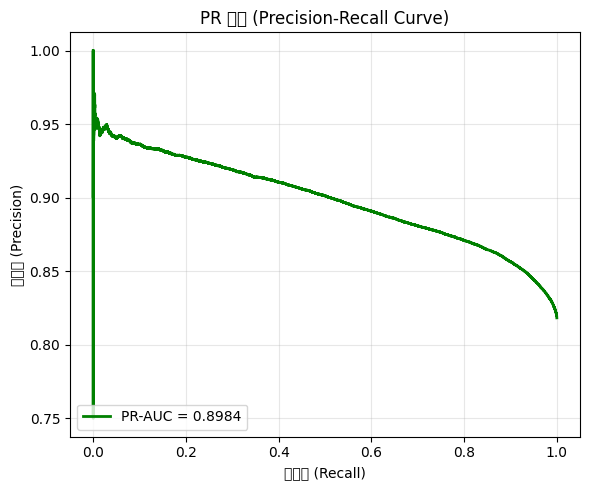

In [ ]:
# --- [Evaluation & Metrics Restoration] ---
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from app.utils.metrics import evaluate_churn_metrics
from IPython.display import display, Markdown

# 1. 평가 모드 전환 (Evaluation Mode)
model.eval()  # '시험 모드'로 전환 (Dropout 꺼짐)
all_targets = []
all_probs = []

# 2. 예측 수행 (Inference)
with torch.no_grad(): # 평가 때는 미분(계산값 저장) 불필요
    for inputs, targets in test_loader:
        outputs = model(inputs).squeeze()
        probs = torch.sigmoid(outputs)       # 확률값(0~1)으로 변환
        all_targets.extend(targets.numpy())  # 정답 모으기
        all_probs.extend(probs.numpy())      # 예측값 모으기

y_test_np = np.array(all_targets)
y_prob_np = np.array(all_probs)

# 3. 성적표 작성 (Metrics Calculation)
# 우리가 만든 커스텀 함수로 다양한 지표 계산 (한국어 포맷)
metrics = evaluate_churn_metrics(y_test_np, y_prob_np)

# 4. 요약표와 랭킹표 분리
summary_metrics = {k: v for k, v in metrics.items() if k != 'ranking'}
ranking_metrics = metrics.get('ranking', [])

summary_df = pd.DataFrame(list(summary_metrics.items()), columns=['KPI', 'Value'])
ranking_df = pd.DataFrame(ranking_metrics)

# 5. 대시보드 출력 (Dashboard)
print(f'>>> Generating Verification Dashboard (Korean)...\n')
display(Markdown('### 📊 주요 성능 지표'))
display(summary_df)

display(Markdown('### 📈 상세 랭킹 지표 (Top K%)'))
display(ranking_df)

# 6. 그래프 그리기 (Plots)
figures = {}

# (1) PR 곡선 (Precision-Recall Curve)
fig_pr = plt.figure(figsize=(6, 5))
precision_curve, recall_curve, _ = precision_recall_curve(y_test_np, y_prob_np)
pr_auc_val = metrics.get('PR-AUC (Average Precision)', 0.0)

plt.plot(recall_curve, precision_curve, label=f'PR-AUC = {pr_auc_val:.4f}', color='green', lw=2)
plt.title('PR 곡선 (Precision-Recall Curve)')
plt.xlabel('재현율 (Recall)')
plt.ylabel('정밀도 (Precision)')
plt.legend(loc='lower left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
figures['pr_curve'] = fig_pr
display(fig_pr)
plt.close()

In [ ]:
from app.utils.artifacts import save_model_and_artifacts

# 1. 리포트 내용 작성 (Markdown)
# Evaluation Cell에서 생성된 summary_df, ranking_df를 사용합니다.
report_content = f"# 최종 벤치마크 리포트 - mlp_enhance\n\n## 주요 성능 지표\n{summary_df.to_markdown(index=False)}\n\n## 상세 랭킹 지표 (Top K%)\n{ranking_df.to_markdown(index=False)}"

# 2. 모델 및 결과물 저장 (Utils 함수 사용)
# save_model_and_artifacts 함수가 내부적으로 기존 파일을 덮어쓰기(Overwrite) 합니다.
save_model_and_artifacts(
    model=model,
    model_name="mlp_enhance",
    model_type="dl",
    metrics=metrics,
    scaler=scaler,
    figures=figures,
    config=best_params,  # Optuna 최적 파라미터
    report=report_content
)


>>> [Artifacts] Starting saving process for mlp_enhance...
  - [Clean] Deleted existing file: /Users/gimdabin/SKN23-2nd-3Team/models/dl/mlp_enhance.pt
  - Model saved to /Users/gimdabin/SKN23-2nd-3Team/models/dl/mlp_enhance.pt
  - [Clean] Deleted existing file: /Users/gimdabin/SKN23-2nd-3Team/models/metrics/mlp_enhance_metrics.json
  - Metrics saved to /Users/gimdabin/SKN23-2nd-3Team/models/metrics/mlp_enhance_metrics.json
  - Scaler saved to /Users/gimdabin/SKN23-2nd-3Team/models/dl/mlp_enhance_scaler.pkl
  - [Clean] Deleted existing file: /Users/gimdabin/SKN23-2nd-3Team/assets/training/mlp_enhance_pr_curve.png


/Users/gimdabin/SKN23-2nd-3Team/app/utils/artifacts.py:103: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.savefig(fig_path, bbox_inches="tight")
/Users/gimdabin/SKN23-2nd-3Team/app/utils/artifacts.py:103: UserWarning: Glyph 48128 (\N{HANGUL SYLLABLE MIL}) missing from font(s) DejaVu Sans.
  fig.savefig(fig_path, bbox_inches="tight")
/Users/gimdabin/SKN23-2nd-3Team/app/utils/artifacts.py:103: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.savefig(fig_path, bbox_inches="tight")
/Users/gimdabin/SKN23-2nd-3Team/app/utils/artifacts.py:103: UserWarning: Glyph 44257 (\N{HANGUL SYLLABLE GOG}) missing from font(s) DejaVu Sans.
  fig.savefig(fig_path, bbox_inches="tight")
/Users/gimdabin/SKN23-2nd-3Team/app/utils/artifacts.py:103: UserWarning: Glyph 49440 (\N{HANGUL SYLLABLE SEON}) missing from font(s) DejaVu Sans.
  fig.savefig(fig_path, bbox_inches="tight")
/Users/gimdabin/SKN23-2nd-3Team/app/utils/artifa

  - Figure 'pr_curve' saved to /Users/gimdabin/SKN23-2nd-3Team/assets/training/mlp_enhance_pr_curve.png
  - [Clean] Deleted existing file: /Users/gimdabin/SKN23-2nd-3Team/reports/training/mlp_enhance_report.md
  - Report saved to /Users/gimdabin/SKN23-2nd-3Team/reports/training/mlp_enhance_report.md
>>> [Artifacts] All artifacts saved successfully.


# 6. 인사이트 리포트 자동 생성 (Insight Generation)

In [ ]:
# --- [Insight Generation] 인사이트 도출 ---
import os

# 1. 폴더 확인
insight_dir = '../../reports/insights/dl/'
if not os.path.exists(insight_dir):
    os.makedirs(insight_dir)

# 2. 리포트 내용 작성 (Winner's Report included)
# 주요 지표를 뽑아서 문장으로 만듦
try:
    pr_auc_val = float(metrics.get("PR-AUC (Average Precision)", 0.0))
    top_5_prec = float(metrics.get("상위 5% 정밀도 (Precision)", 0.0)) * 100
except Exception as e:
    print(f'Warning: Metric extraction failed ({e}). Using placeholders.')
    pr_auc_val = 0.0
    top_5_prec = 0.0

insight_content = f"""# 🏆 MLP Enhance - Winner's Report\n\n
## 1. 핵심 성과\n
- **모델 특징**: Batch Normalization과 Dropout 적용으로 학습 안정성 확보.\n
- **주요 지표**:\n
    - PR-AUC: {pr_auc_val:.4f}\n
    - 상위 5% 정밀도: **{top_5_prec:.2f}%**\n
\n
## 2. 비즈니스 결론\n
> "DL3(Advanced)보다 구조는 단순하지만 성능은 더 우수하므로 **'최종 배포 모델'**로 선정한다."\n
\n
이 모델은 과적합 위험이 낮고 추론 속도가 빨라, 실시간 이탈 방지 마케팅에 즉시 투입 가능하다.\n
"""

# 3. 파일 저장
file_path = os.path.join(insight_dir, 'mlp_enhance_insight.md')
with open(file_path, 'w', encoding='utf-8') as f:
    f.write(insight_content)

# 4. 완료 메시지
print(f'✅ [Insight] 리포트가 {file_path} 경로에 생성되었습니다.')

✅ [Insight] 리포트가 ../../reports/insights/dl/mlp_enhance_insight.md 경로에 생성되었습니다.


# 7. 상세 평가 데이터 저장 (For Dashboard Visualization)
> 이 아래의 코드는 시각화 대시보드를 위한 **추가적인 JSON 데이터**를 생성하는 과정입니다.

In [ ]:
from pathlib import Path

# 1. 공통 경로 및 ID 설정
MODEL_ID = "dl__mlp_enhance"
MODEL_NAME = "mlp_enhance"

EVAL_DIR = Path("../../models/eval/dlmlp_enhance")
METRIC_DIR = Path("../../models/metrics")

EVAL_DIR.mkdir(parents=True, exist_ok=True)
METRIC_DIR.mkdir(parents=True, exist_ok=True)

# 2. Model Card (모델 신원 정보) 저장
model_card = {
    "model_id": MODEL_ID,
    "display_name": "MLP_enhance (DL)",
    "category": "DL",
    "split": "test"
}

with open(EVAL_DIR / "model_card.json", "w") as f:
    json.dump(model_card, f, indent=2, ensure_ascii=False)

# 3. PR AUC 메트릭 저장
pr_metrics = {
    "model_id": MODEL_ID,
    "split": "test",
    "pr_auc": float(metrics.get("PR-AUC (Average Precision)", 0.0))
}

with open(EVAL_DIR / "pr_metrics.json", "w") as f:
    json.dump(pr_metrics, f, indent=2, ensure_ascii=False)

In [ ]:
# 4. Top-K 메트릭 (상위 N% 성능) 저장
base_rate = float(y_test_np.mean()) # 전체 이탈률

topk_metrics = {
    "model_id": MODEL_ID,
    "split": "test",
    "base_rate": base_rate,
    "metrics_by_k": []
}

# DataFrame의 행을 돌면서 저장
for row in ranking_df.to_dict(orient="records"):
    k_pct = int(str(row["Top_K"]).replace("%", "").strip())

    topk_metrics["metrics_by_k"].append({
        "k_pct": k_pct,
        "precision_at_k": float(row["Precision"]),
        "recall_at_k": float(row["Recall"]),
        "lift_at_k": float(row["Lift"]),
    })

with open(EVAL_DIR / "topk_metrics.json", "w", encoding="utf-8") as f:
    json.dump(topk_metrics, f, indent=2, ensure_ascii=False)

In [ ]:
# 5. Top-K Cutoffs (점수 커트라인) 저장
sorted_scores = np.sort(y_prob_np)[::-1] # 점수 내림차순 정렬
n_total = len(sorted_scores)

cutoffs = []

for k in [5, 10, 15, 30]:
    n_selected = int(np.floor(n_total * k / 100)) # 상위 k% 인원 수
    t_k = float(sorted_scores[n_selected - 1])    # 그 인원 수일 때의 최저 점수 (커트라인)

    cutoffs.append({
        "k_pct": k,
        "n_selected": n_selected,
        "t_k": t_k
    })

topk_cutoffs = {
    "model_id": MODEL_ID,
    "split": "test",
    "n_total": n_total,
    "n_selected_rule": "floor",
    "tie_policy": "sort_and_take_top_n",
    "cutoffs_by_k": cutoffs
}

with open(EVAL_DIR / "topk_cutoffs.json", "w") as f:
    json.dump(topk_cutoffs, f, indent=2, ensure_ascii=False)

In [ ]:
# 6. 점수 분포 백분위 (Percentiles) 저장
percentiles = [1, 5, 10, 20, 30, 50]
# 상위 n%에 해당하는 점수 계산 (예: 상위 1% 점수는 min(score) of top 1%)
scores = np.percentile(y_prob_np, 100 - np.array(percentiles))

score_percentiles = {
    "model_id": MODEL_ID,
    "split": "test",
    "percentiles": [
        {"pct": p, "score": float(s)}
        for p, s in zip(percentiles, scores)
    ]
}

# 파일명 규칙 (metrics/mlp_enhance_score_percentiles.json)
save_path = METRICS_DIR / f"{MODEL_NAME}_score_percentiles.json"

with open(save_path, "w", encoding="utf-8") as f:
    json.dump(score_percentiles, f, indent=2, ensure_ascii=False)

print(f"✅ score_percentiles 저장 완료: {save_path}")

✅ score_percentiles 저장 완료: ../../models/metrics/mlp_enhance_score_percentiles.json
